In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
#load test data
train_data = pd.read_csv("./data/train.csv")
test_cols = pd.read_csv("./data/test.csv")
test_preds = pd.read_csv("./submissions/submission.csv")
test_w_preds = pd.concat([test_cols, test_preds], axis = 1)

In [3]:
#number of columns:
print(len(test_cols.columns))

127


In [4]:
#datatype by col
for col in test_cols.columns:
    print(f"{col} -- Type: {type(test_cols[col][0])}")

Id -- Type: <class 'numpy.int64'>
Product_Info_1 -- Type: <class 'numpy.int64'>
Product_Info_2 -- Type: <class 'str'>
Product_Info_3 -- Type: <class 'numpy.int64'>
Product_Info_4 -- Type: <class 'numpy.float64'>
Product_Info_5 -- Type: <class 'numpy.int64'>
Product_Info_6 -- Type: <class 'numpy.int64'>
Product_Info_7 -- Type: <class 'numpy.int64'>
Ins_Age -- Type: <class 'numpy.float64'>
Ht -- Type: <class 'numpy.float64'>
Wt -- Type: <class 'numpy.float64'>
BMI -- Type: <class 'numpy.float64'>
Employment_Info_1 -- Type: <class 'numpy.float64'>
Employment_Info_2 -- Type: <class 'numpy.int64'>
Employment_Info_3 -- Type: <class 'numpy.int64'>
Employment_Info_4 -- Type: <class 'numpy.float64'>
Employment_Info_5 -- Type: <class 'numpy.int64'>
Employment_Info_6 -- Type: <class 'numpy.float64'>
InsuredInfo_1 -- Type: <class 'numpy.int64'>
InsuredInfo_2 -- Type: <class 'numpy.int64'>
InsuredInfo_3 -- Type: <class 'numpy.int64'>
InsuredInfo_4 -- Type: <class 'numpy.int64'>
InsuredInfo_5 -- Typ

In [5]:
#missing values by column
print("Number of NaNs:", test_cols.isna().sum()[test_cols.isna().sum() != 0])

Number of NaNs: Employment_Info_1          3
Employment_Info_4       2137
Employment_Info_6       3787
Insurance_History_5     8105
Family_Hist_2           9880
Family_Hist_3          11064
Family_Hist_4           6677
Family_Hist_5          13624
Medical_History_1       2972
Medical_History_10     19564
Medical_History_15     14864
Medical_History_24     18585
Medical_History_32     19414
dtype: int64


/var/folders/71/kb4k864551d0xx5bt9s_n_qh0000gn/T/ipykernel_30257/1264141539.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


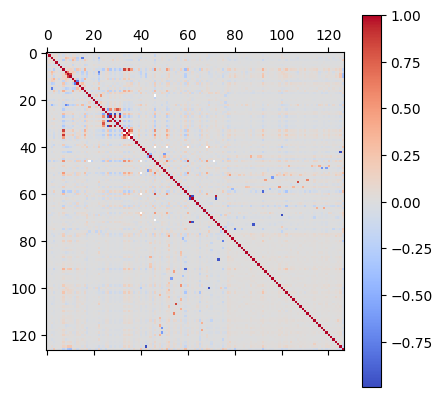

In [56]:
#correlations
corr_mat = train_data.drop("Product_Info_2", axis = 1).corr()
cax = plt.matshow(corr_mat, cmap = "coolwarm")
plt.colorbar(cax)
plt.tight_layout()
plt.show()

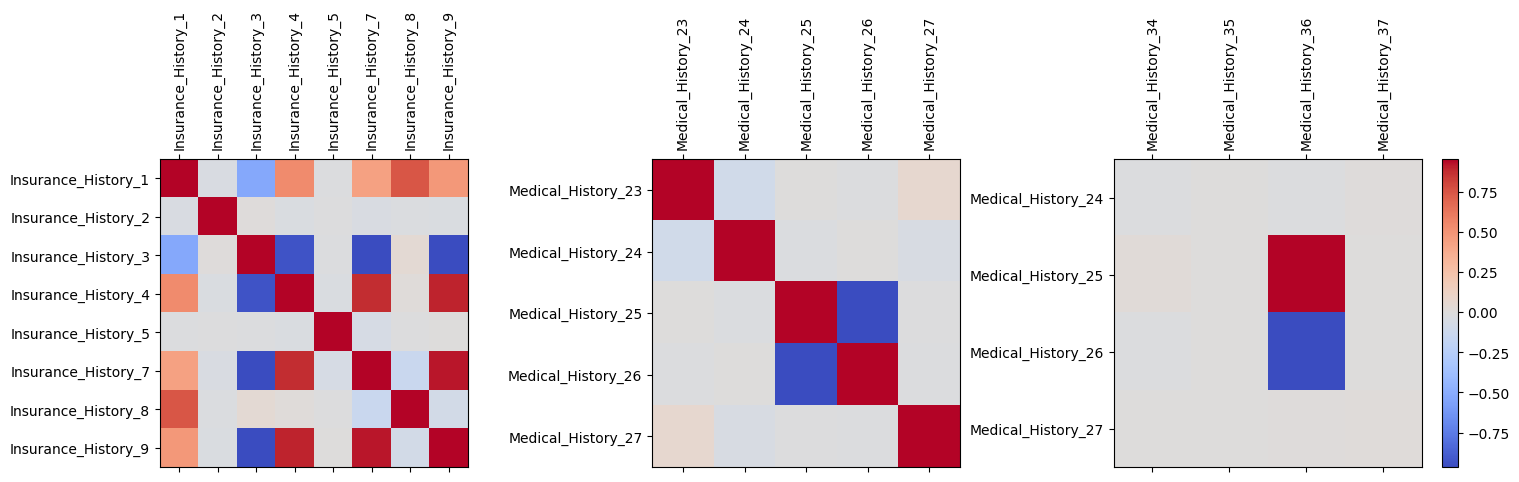

In [57]:
#examining some of those high correlation areas
corr_mat = train_data.drop("Product_Info_2", axis = 1).corr()
ins_history_subset = train_data.loc[:, "Insurance_History_1":"Insurance_History_9"].corr()
med_history_subset = train_data.iloc[:, 60:65].corr()
med_history_subset_2 = train_data.drop("Product_Info_2", axis = 1).corr().iloc[60:64, 70:74]

matrices = [ins_history_subset, med_history_subset, med_history_subset_2]

fig, axes = plt.subplots(1,3, figsize = (18, 4))
for i, ax in enumerate(axes.flat):
    cax = ax.matshow(matrices[i], cmap = "coolwarm")
    ax.set_xticks(range(len(matrices[i].columns)), matrices[i].columns, rotation=90)
    ax.set_yticks(range(len(matrices[i].columns)), matrices[i].columns, rotation=0)

#setting ticks for this one manually since its an asymmetric slice and requires a different method
axes[2].set_xticks(range(len(med_history_subset_2.columns)), corr_mat.columns[70:74], rotation=90)
axes[2].set_yticks(range(len(med_history_subset_2.columns)), corr_mat.columns[60:64], rotation=0)

fig.colorbar(cax)
plt.show()

Text(0, 0.5, 'Proportion')

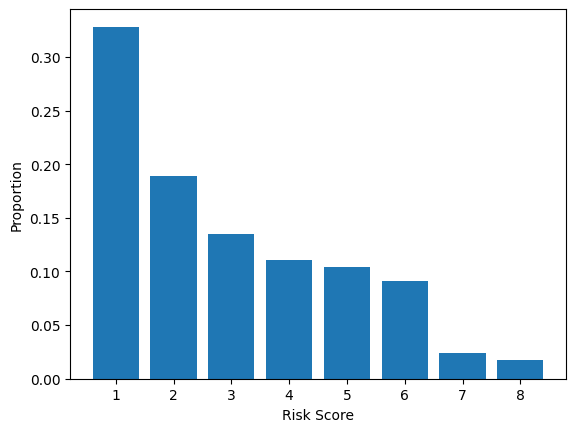

In [62]:
#distribution of response (train set)

plt.bar(range(1, 8+1), (train_data["Response"].value_counts() / len(train_data)))
plt.xlabel("Risk Score")
plt.ylabel("Proportion")

Text(0, 0.5, 'Count')

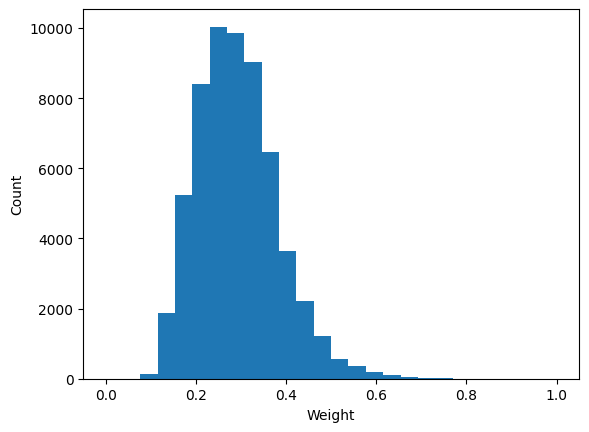

In [86]:
#dist of weight
plt.hist(train_data["Wt"], bins = 26)
plt.xlabel("Weight")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

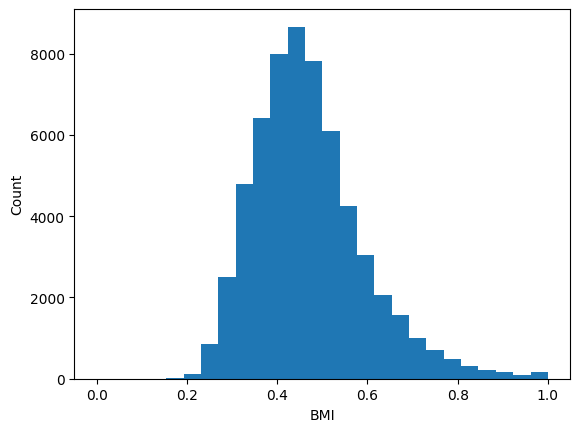

In [84]:
#dist of bmi
plt.hist(train_data["BMI"], bins = 26)
plt.xlabel("BMI")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

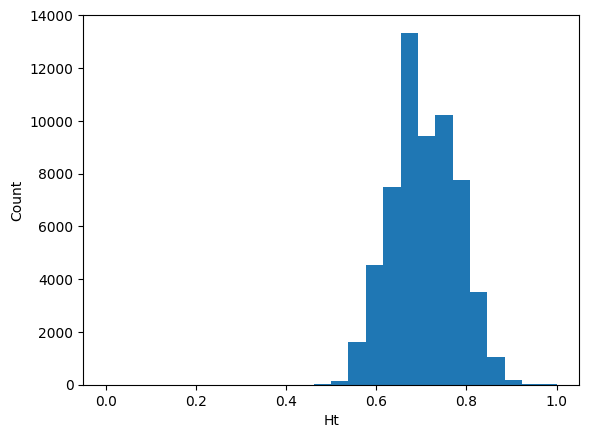

In [85]:
#dist of height
plt.hist(train_data["Ht"], bins = 26)
plt.xlabel("Ht")
plt.ylabel("Count")

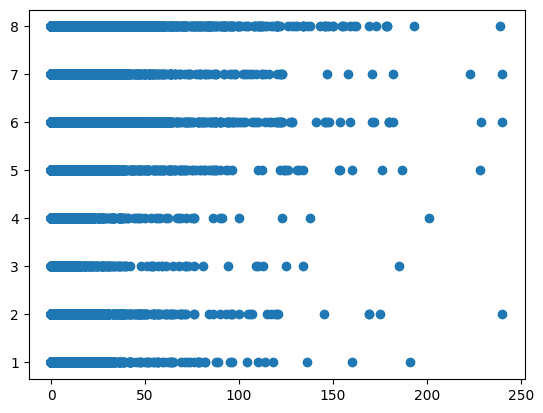

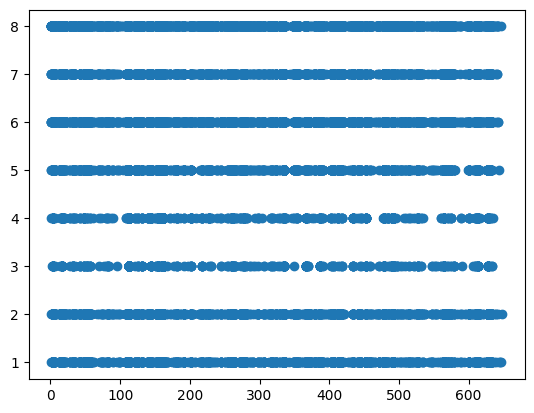

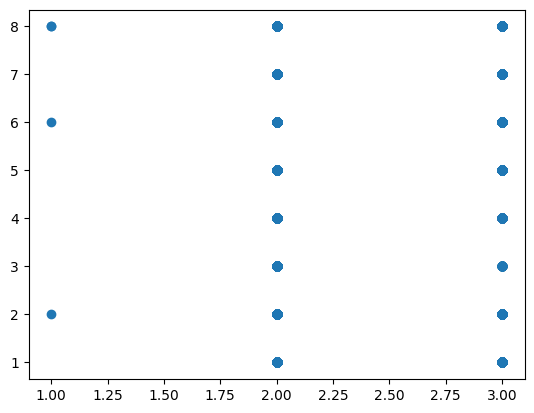

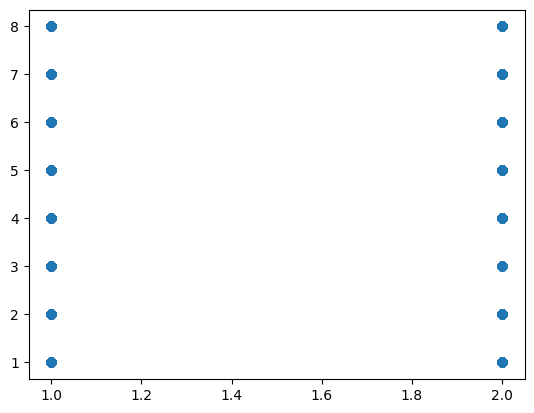

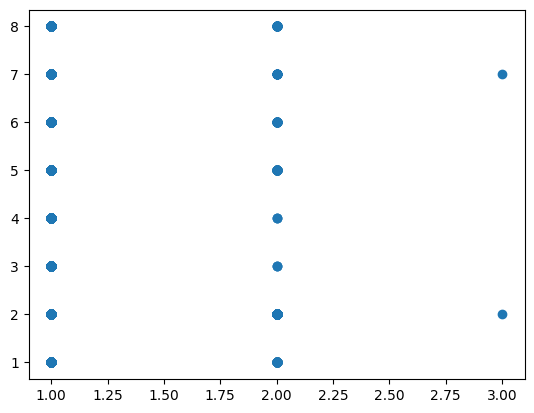

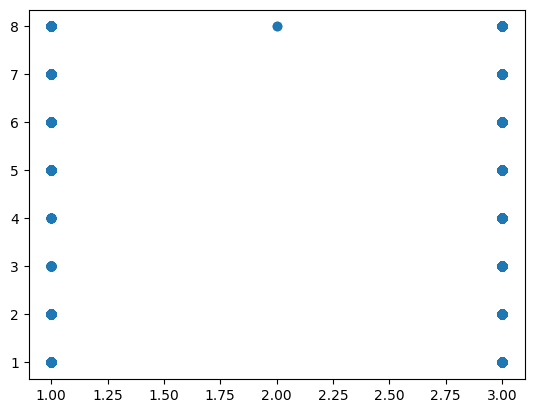

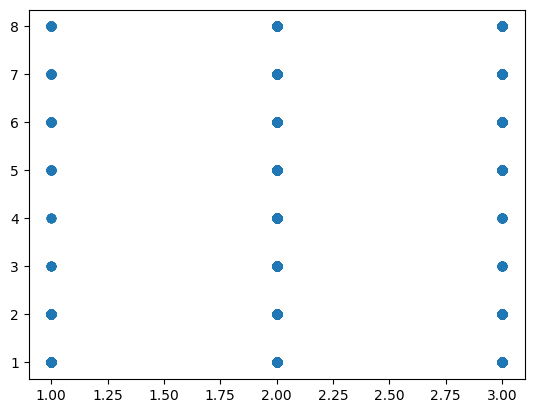

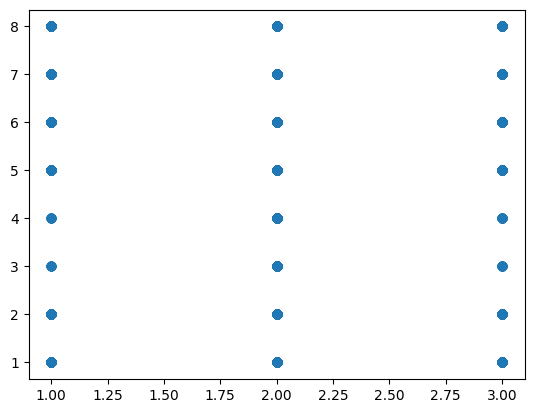

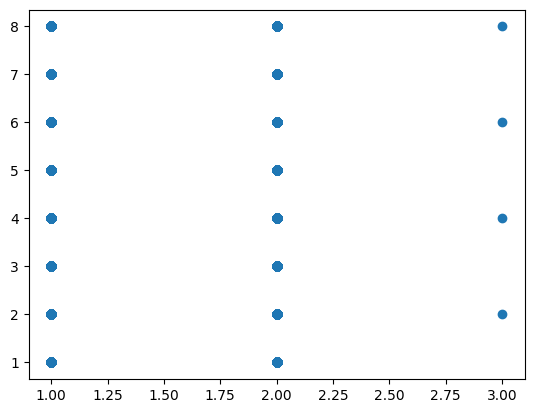

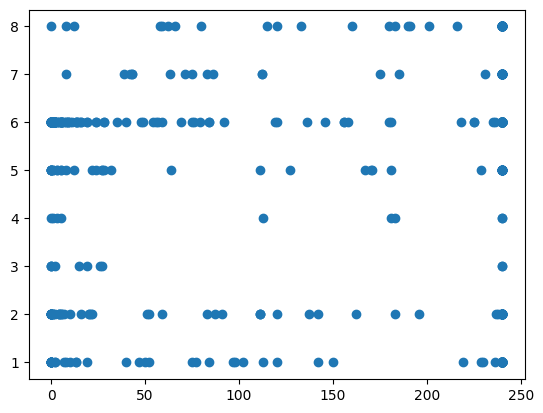

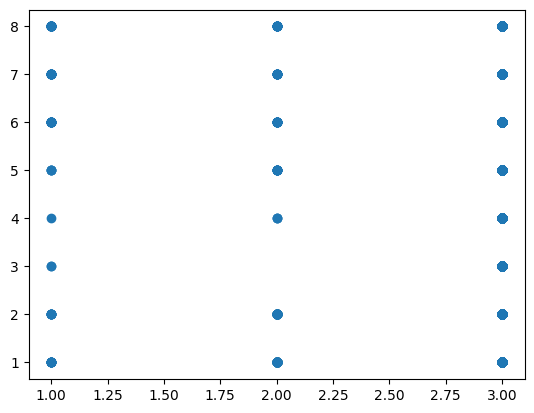

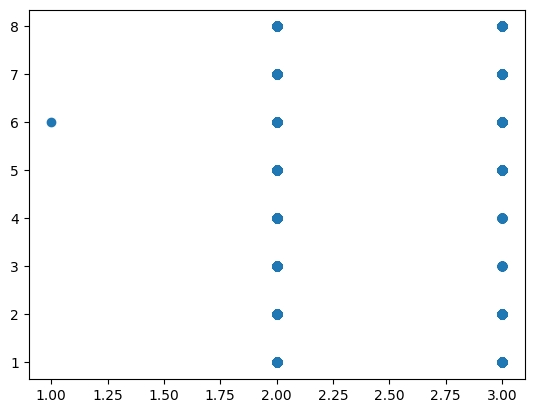

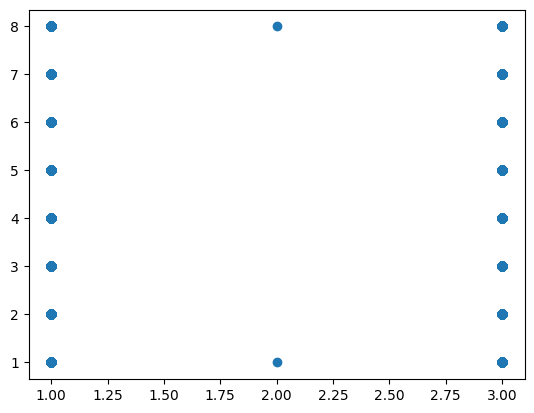

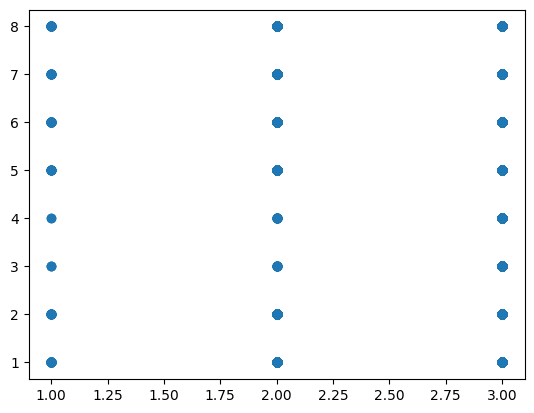

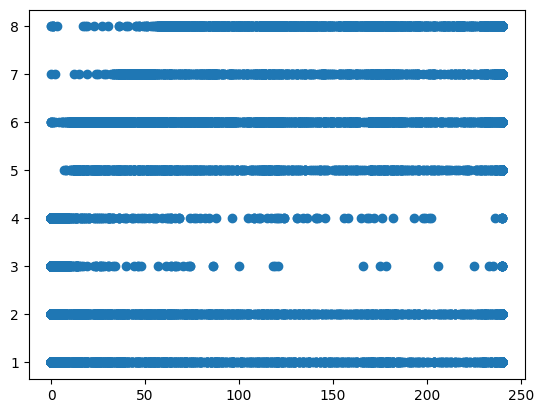

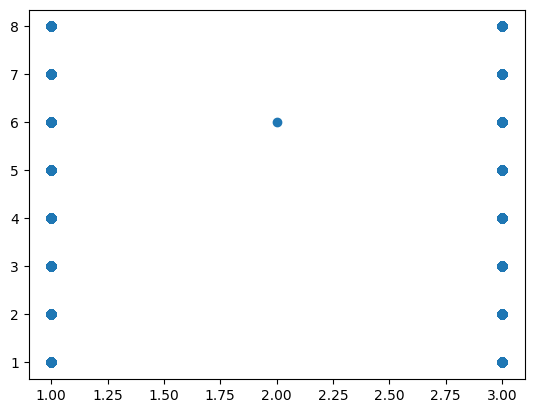

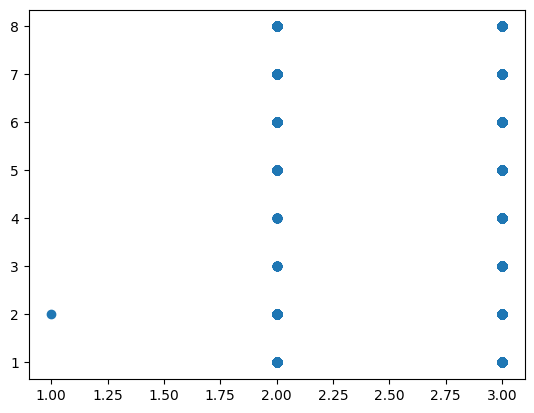

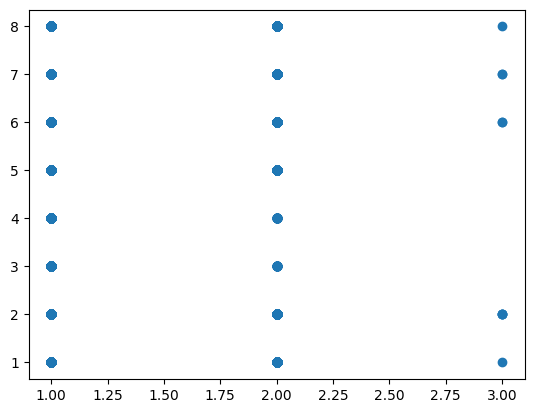

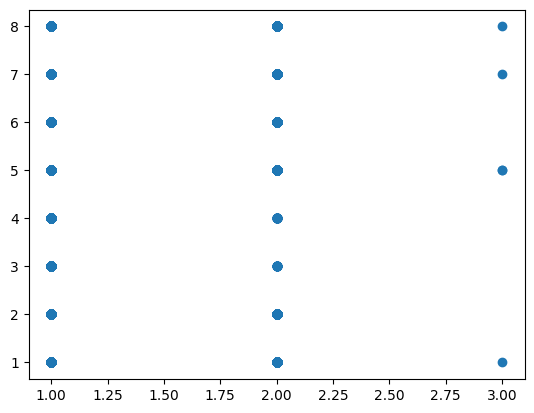

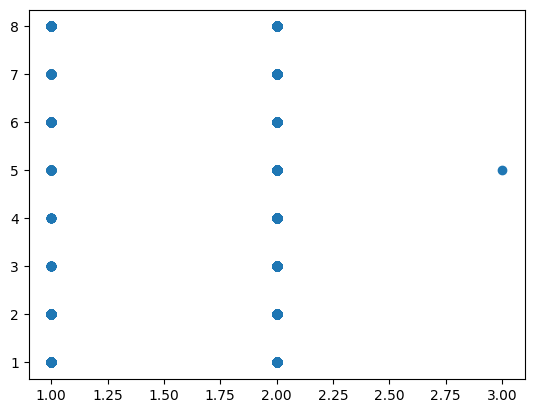

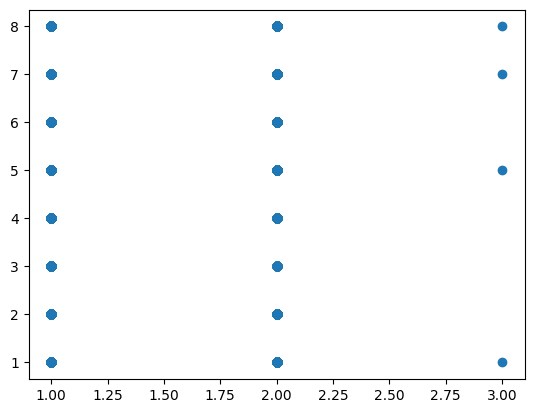

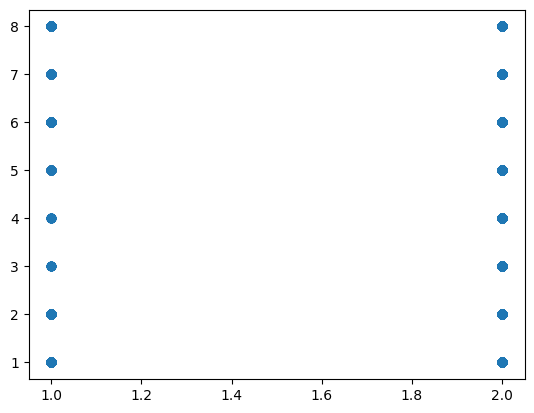

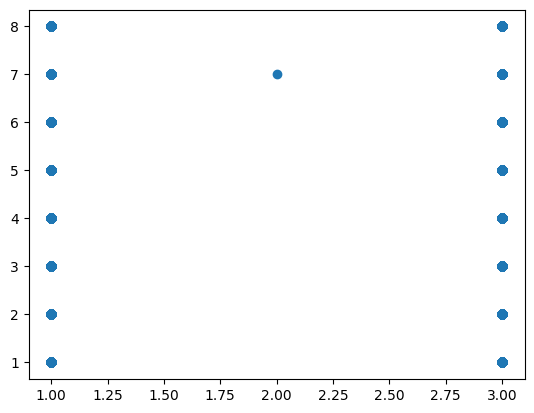

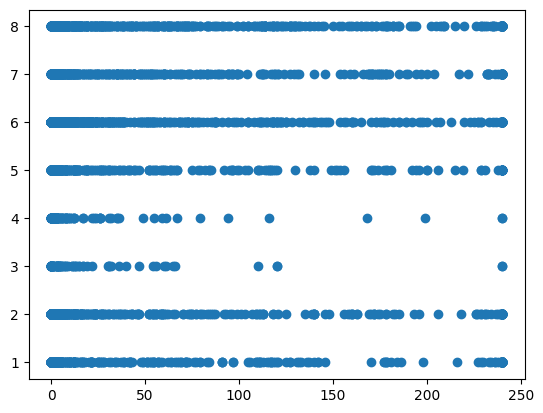

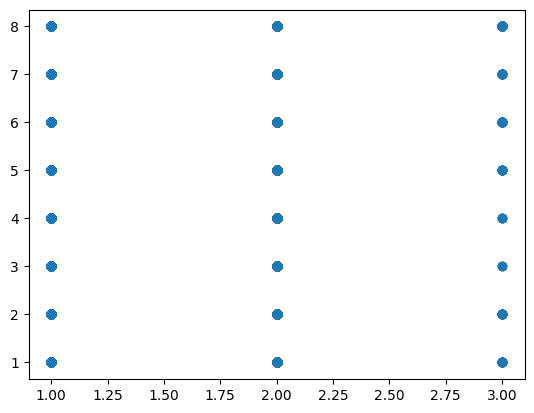

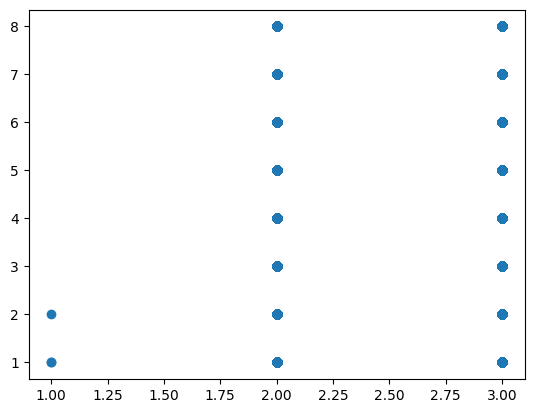

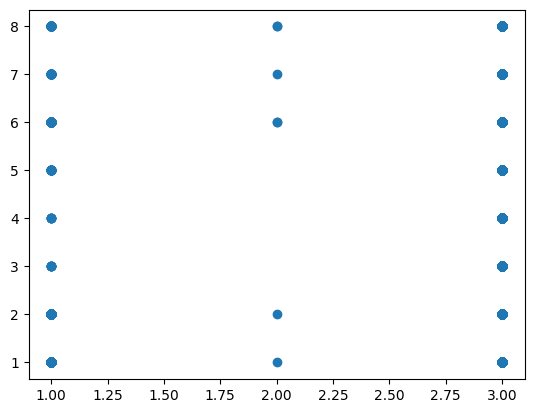

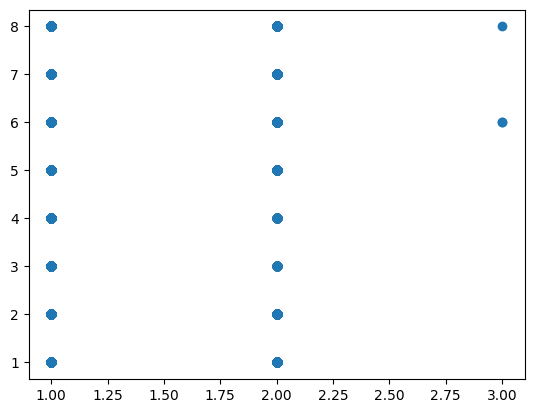

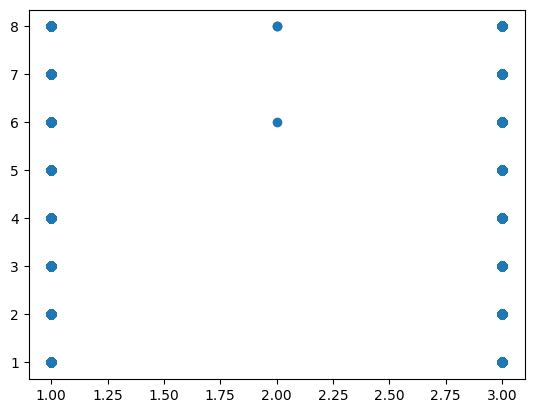

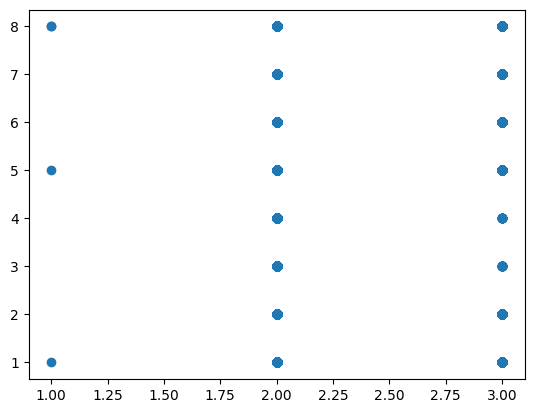

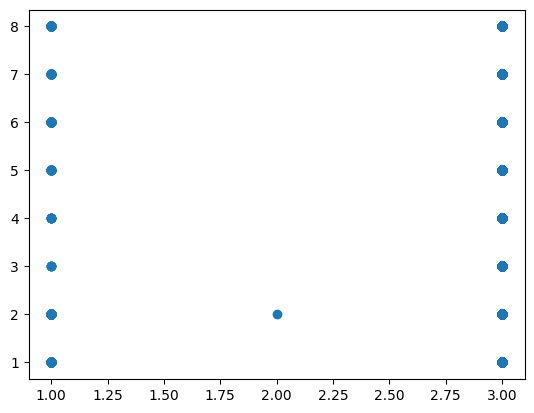

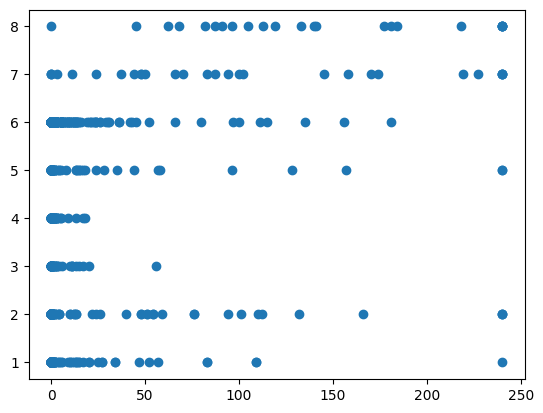

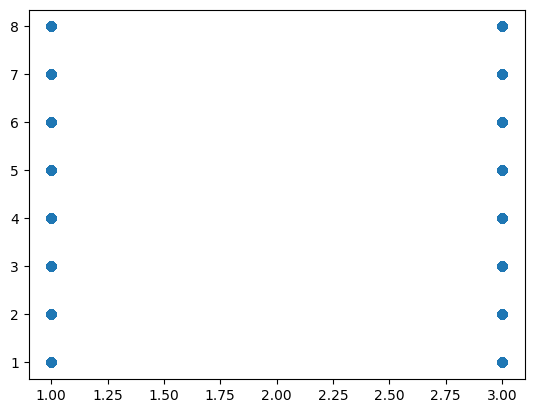

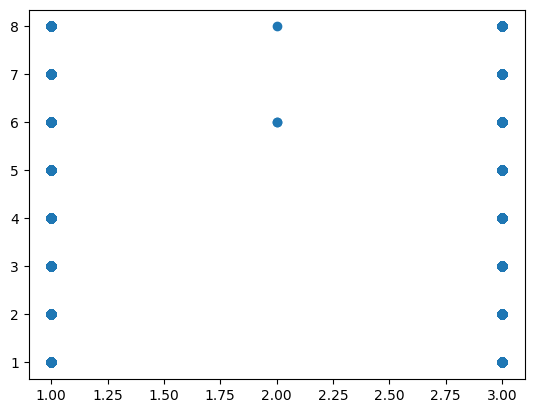

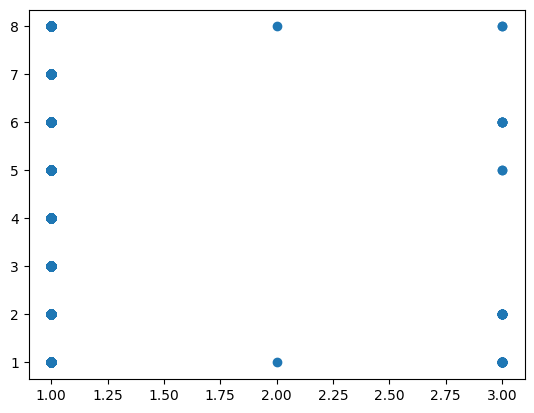

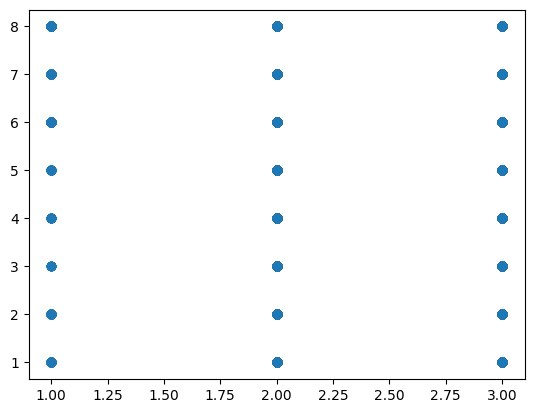

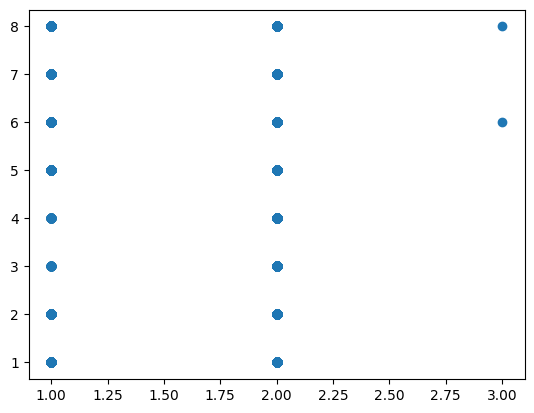

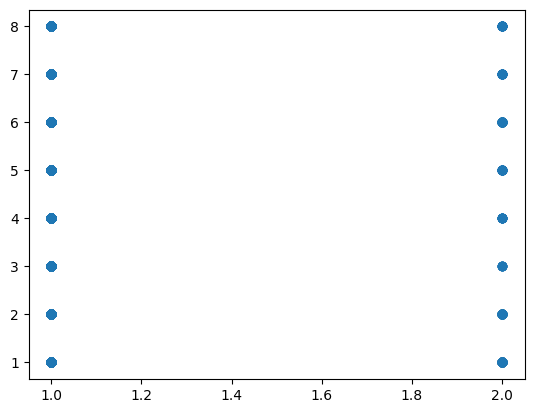

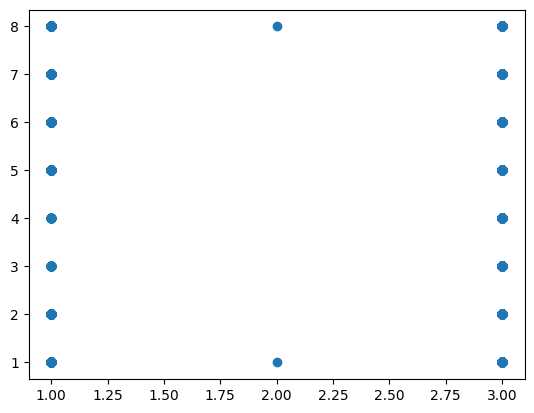

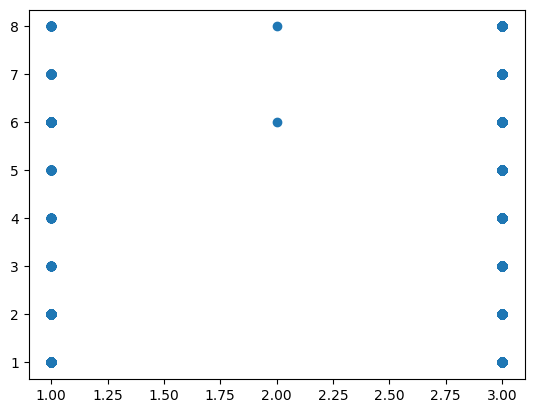

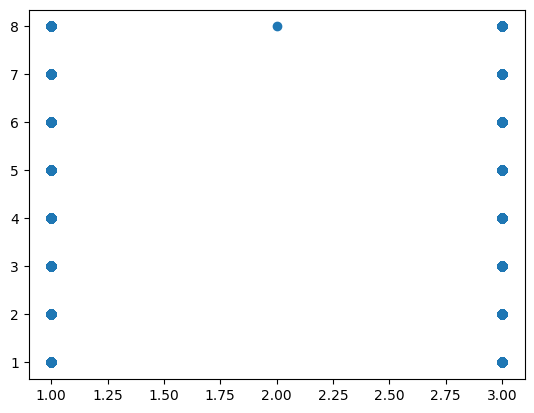

In [83]:
#some medical history plots
base = "Medical_History_"

for i in range(1, 42):
    plt.scatter(train_data[base + str(i)], train_data["Response"])
    plt.show()

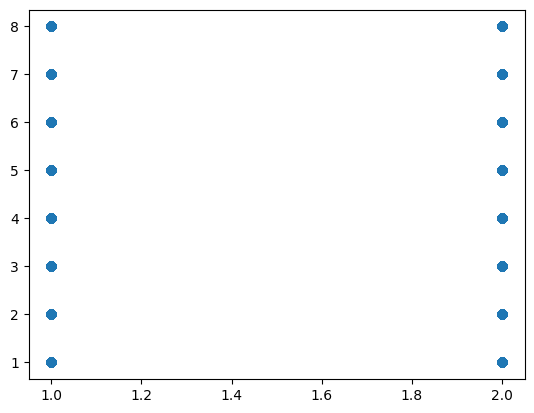

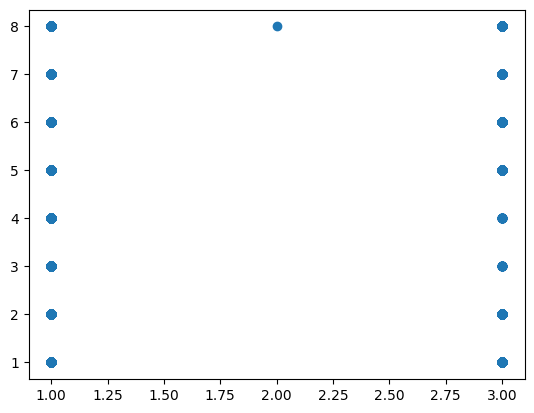

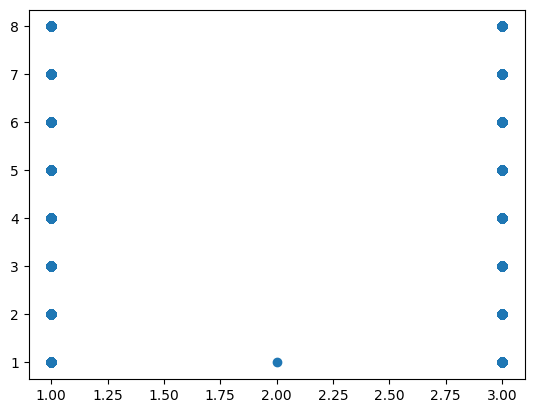

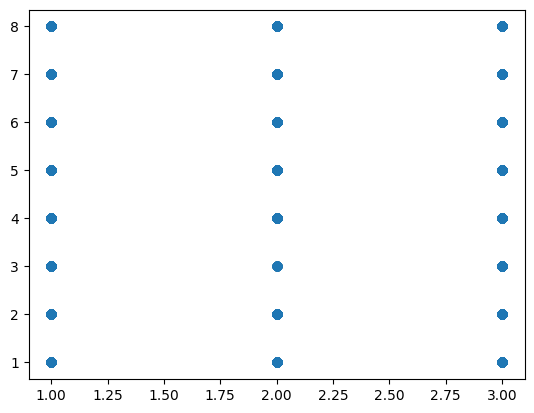

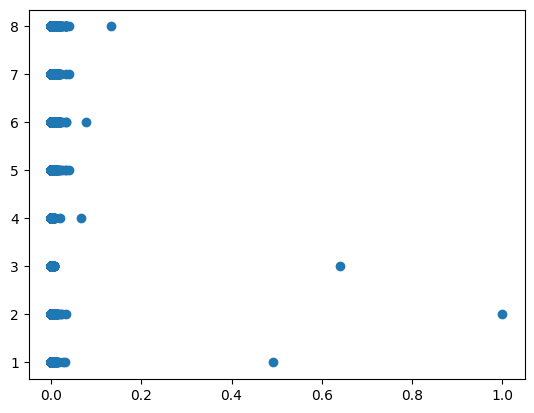

In [79]:
#some insurance history plots
base = "Insurance_History_"
for i in range(1, 6):
    plt.scatter(train_data[base + str(i)], train_data["Response"])
    plt.show()